# End-to-End FINN Flow for a Simple Convolutional Net
-----------------------------------------------------------------

In this notebook, we will go through the FINN steps needed to take a binarized convolutional network all the way down to a heterogeneous streaming dataflow accelerator running on the FPGA. 

## 1. Brevitas Export, FINN Import and Tidy-Up

Similar to what we did in the TFC-w1a1 end-to-end notebook, we will start by exporting the [pretrained CNV-w1a1 network](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq) to ONNX, importing that into FINN and running the "tidy-up" transformations to have a first look at the topology. The network will be exported in QONNX format and then converted into the FINN-ONNX format to prepare it for the FINN compiler.

In [1]:
import torch
import onnx

from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron
from finn.util.test import get_test_model_trained
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

In [2]:
build_dir = "./"

In [3]:
cnv = get_test_model_trained("CNV", 1, 1)
export_onnx_path = build_dir + "/end2end_cnv_w1a1_export.onnx"
export_qonnx(cnv, torch.randn(1, 3, 32, 32), export_onnx_path)
qonnx_cleanup(export_onnx_path, out_file=export_onnx_path)

model = ModelWrapper(export_onnx_path)
model = model.transform(ConvertQONNXtoFINN())
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + "/end2end_cnv_w1a1_tidy.onnx")

Now that the model is exported, let's have a look at its layer structure with Netron. Remember that the visualization below is interactive, you can click on the individual nodes and view the layer attributes, trained weights and so on.

In [4]:
showInNetron(build_dir+"/end2end_cnv_w1a1_tidy.onnx")

Serving './/end2end_cnv_w1a1_tidy.onnx' at http://0.0.0.0:8081


You can see that the network is composed of a repeating convolution-convolution-maxpool layer pattern to extract features using 3x3 convolution kernels (with weights binarized), followed by fully connected layers acting as the classifier. Also notice the initial `MultiThreshold` layer at the beginning of the network, which is quantizing float inputs to 8-bit ones.

### Adding Pre- and Postprocessing <a id='prepost'></a>

Preprocessing and postprocessing steps can be added directly in the ONNX graph. In this case, the preprocessing step divides the input `uint8` data by 255 so the inputs to the CNV-w1a1 network are bounded between [0, 1]. The postprocessing step takes the output of the network and returns the index (0-9) of the image category with the highest probability (top-1). 

In [5]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)

# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir + "/end2end_cnv_w1a1_preproc.onnx"
export_qonnx(totensor_pyt, torch.randn(ishape), chkpt_preproc_name)
qonnx_cleanup(chkpt_preproc_name, out_file=chkpt_preproc_name)
pre_model = ModelWrapper(chkpt_preproc_name)
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

/home/surajkarki/workspace/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [6]:
from qonnx.transformation.insert_topk import InsertTopK
from qonnx.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir + "/end2end_cnv_w1a1_pre_post.onnx"

# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

In [7]:
showInNetron(build_dir+"/end2end_cnv_w1a1_pre_post.onnx", port=2222)

Serving './/end2end_cnv_w1a1_pre_post.onnx' at http://0.0.0.0:2222


## 2. How FINN Implements Convolutions: Lowering and Streamlining

In FINN, we implement convolutions with the *lowering* approach: we convert them to matrix-matrix multiply operations, where one of the matrices is generated by sliding a window over the input image. You can read more about the sliding window operator and how convolution lowering works [in this notebook](https://github.com/maltanar/qnn-inference-examples/blob/master/3-convolutional-binarized-gtsrb.ipynb). The streaming dataflow architecture we will end up with is going to look something like this figure from the [FINN-R paper](https://arxiv.org/abs/1809.04570):

![](cnv-mp-fc.png)

Note how the convolution layer looks very similar to the fully connected one in terms of the matrix-vector-threshold unit (MVTU) or sometimes called matrix-vector-activation unit (MVAU). But now the MVTU is preceded by a sliding window unit that produces the matrix from the input image. All of these building blocks, including the `MaxPool` layer you see in this figure, exist as templated Vitis HLS C++ functions in [finn-hlslib](https://github.com/Xilinx/finn-hlslib) and/or as RTL modules in [finn-rtllib](https://github.com/Xilinx/finn/tree/main/finn-rtllib).


To target this kind of hardware architecture with our network we'll apply a convolution lowering transformation, in addition to streamlining. You may recall the *streamlining transformation* that we applied to the TFC-w1a1 network, which is a series of mathematical simplifications that allow us to get rid of floating point scaling operations by implementing few-bit activations as thresholding operations. 

**The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

In [8]:
from finn.transformation.streamline import Streamline
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + "/end2end_cnv_w1a1_streamlined.onnx")

We won't go into too much detail about what happens in each transformation and why they are called in the particular order they are (feel free to visualize the intermediate steps using Netron yourself if you are curious) but here is a brief summary:

* `Streamline` moves floating point scaling and addition operations closer to the input of the nearest thresholding activation and absorbs them into thresholds
* `LowerConvsToMatMul` converts ONNX `Conv` nodes into sequences of `Im2Col, MatMul` nodes as discussed above. `Im2Col` is a custom FINN ONNX high-level node type that implements the sliding window operator.
* `MakeMaxPoolNHWC` and `AbsorbTransposeIntoMultiThreshold` convert the *data layout* of the network into the NHWC data layout that finn-hlslib and finn-rtllib primitives use. NCHW means the tensor dimensions are ordered as `(N : batch, H : height, W : width, C : channels)` (assuming 2D images). The ONNX standard ops normally use the NCHW layout, but the ONNX intermediate representation itself does not dictate any data layout.
* You may recall `ConvertBipolarMatMulToXnorPopcount` from the TFC-w1a1 example, which is needed to implement bipolar-by-bipolar (w1a1) networks correctly using finn-hlslib.

Let's visualize the streamlined and lowered network with Netron. Observe how all the `Conv` nodes have turned into pairs of `Im2Col, MatMul` nodes, and many nodes including `BatchNorm, Mul, Add` nodes have disappeared and replaced with `MultiThreshold` nodes.

In [10]:
showInNetron(build_dir + "/end2end_cnv_w1a1_streamlined.onnx", port=2222)

Serving './/end2end_cnv_w1a1_streamlined.onnx' at http://0.0.0.0:2222


## 3. Partitioning, Conversion to HW Layers and Folding

The next steps will be (again) very similar to what we did for the TFC-w1a1 network. We'll first convert the layers that we can put into the FPGA into their HW equivalents, separate them out into a *dataflow partition* and specialize them to HLS variants:


In [11]:
from finn.util.basic import pynq_part_map

# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 10

import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.infer_data_layouts import InferDataLayouts

model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_streamlined.onnx")
model = model.transform(to_hw.InferBinaryMatrixVectorActivation())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
# TopK to LabelSelect
model = model.transform(to_hw.InferLabelSelectLayer())
# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())
model = model.transform(to_hw.InferConvInpGen())
model = model.transform(to_hw.InferStreamingMaxPool())
# get rid of Reshape(-1, 1) operation between hw nodes
model = model.transform(RemoveCNVtoFCFlatten())
# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())
# infer tensor data layouts
model = model.transform(InferDataLayouts())
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir + "/end2end_cnv_w1a1_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# save the dataflow partition with a different name for easier access
# and specialize the layers to HLS variants
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model = dataflow_model.transform(SpecializeLayers(fpga_part))
dataflow_model.save(build_dir + "/end2end_cnv_w1a1_dataflow_model.onnx")

Notice the additional `RemoveCNVtoFCFlatten` transformation that was not used for TFC-w1a1. In the last Netron visualization you may have noticed a `Reshape` operation towards the end of the network where the convolutional part of the network ends and the fully-connected layers started. That `Reshape` is essentialy a tensor flattening operation, which we can remove for the purposes of hardware implementation. We can examine the contents of the dataflow partition with Netron, and observe the `ConvolutionInputGenerator`, `MatrixVectorActivation` and `StreamingMaxPool_Batch` nodes that implement the sliding window, matrix multiply and maxpool operations. *Note that the MatrixVectorActivation instances following the ConvolutionInputGenerator nodes are really implementing the convolutions, despite the name. The final three MatrixVectorActivation instances implement actual FC layers.*

In [13]:
showInNetron(build_dir + "/end2end_cnv_w1a1_dataflow_parent.onnx", port=2222)

Serving './/end2end_cnv_w1a1_dataflow_parent.onnx' at http://0.0.0.0:2222


Note that pretty much everything has gone into the `StreamingDataflowPartition` node; the only operation remaining is to apply a `Transpose` to obtain NHWC input from a NCHW input (the ONNX default). 

In [15]:
showInNetron(build_dir + "/end2end_cnv_w1a1_dataflow_model.onnx", port=2222)

Serving './/end2end_cnv_w1a1_dataflow_model.onnx' at http://0.0.0.0:2222


Now we have to set the *folding factors* for certain layers to adjust the performance of our accelerator, similar to the TFC-w1a1 example. We'll also set the desired FIFO depths around those layers, which are important to achieve full throughput in the accelerator.

In [16]:
model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_dataflow_model.onnx")
fc_layers = model.get_nodes_by_op_type("MVAU_hls")
# each tuple is (PE, SIMD, in_fifo_depth) for a layer
folding = [
    (16, 3, [128]),
    (32, 32, [128]),
    (16, 32, [128]),
    (16, 32, [128]),
    (4, 32, [81]),
    (1, 32, [2]),
    (1, 4, [2]),
    (1, 8, [128]),
    (5, 1, [3]),
]
for fcl, (pe, simd, ififodepth) in zip(fc_layers, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififodepth)

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator_rtl")
for i in range(len(swg_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)

model = model.transform(GiveUniqueNodeNames())
model.save(build_dir + "/end2end_cnv_w1a1_folded.onnx")

Below we visualize in Netron to observe the folding factors in the `PE` and `SIMD` attributes of each `MVAU_hls`.

In [18]:
showInNetron(build_dir + "/end2end_cnv_w1a1_folded.onnx", port=2222)

Serving './/end2end_cnv_w1a1_folded.onnx' at http://0.0.0.0:2222


Our network is now ready and we can start with the hardware generation.

## 4. Hardware Generation

From this point onward, the steps we have to follow do not depend on the particular network and will be exactly the same as the TFC-w1a1 example. **which may take about 30 minutes depending on your host computer**. For more details about what's going on in this step, please consult the [TFC end-to-end notebook](tfc_end2end_example.ipynb) or the appropriate section in the [FINN documentation](https://finn.readthedocs.io/en/latest/hw_build.html).

In [19]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_folded.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns))

/home/surajkarki/workspace/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 32 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/home/surajkarki/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:234: UserWarning: Input FIFO for IODMA_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/surajkarki/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:294: UserWarning: Output FIFO for LabelSelect_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/surajkarki/workspace/finn/src/finn/transformation/fpgadataflow/create_stitched_ip.py:290: UserWarning: First node is not StreamingFIFO or IODMA.
                You may experience incorrect stitched-IP rtlsim or hardware
                behavior. It is stron

After the `ZynqBuild` we run one additional transformation to generate a PYNQ driver for the accelerator.

In [20]:
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
model = model.transform(MakePYNQDriver("zynq-iodma"))

In [21]:
model.save(build_dir + "/end2end_cnv_w1a1_synth.onnx")

## 5. Deployment and Execution

The bitfile and generated driver files(s) will be copied into a deployment folder which then can be used to run the network on the PYNQ board.

In [22]:
from shutil import copy
from distutils.dir_util import copy_tree

# create directory for deployment files
deployment_dir = make_build_dir(prefix="pynq_deployment_")
model.set_metadata_prop("pynq_deployment_dir", deployment_dir)

# get and copy necessary files
# .bit and .hwh file
bitfile = model.get_metadata_prop("bitfile")
hwh_file = model.get_metadata_prop("hw_handoff")
deploy_files = [bitfile, hwh_file]

for dfile in deploy_files:
    if dfile is not None:
        copy(dfile, deployment_dir)

# driver.py and python libraries
pynq_driver_dir = model.get_metadata_prop("pynq_driver_dir")
copy_tree(pynq_driver_dir, deployment_dir)

creating /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn
creating /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn/util
copying /tmp/finn_dev_surajkarki/pynq_driver_j19nrnf2/finn/util/__init__.py -> /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn/util
copying /tmp/finn_dev_surajkarki/pynq_driver_j19nrnf2/finn/util/data_packing.py -> /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn/util
creating /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/runtime_weights
copying /tmp/finn_dev_surajkarki/pynq_driver_j19nrnf2/validate.py -> /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx
copying /tmp/finn_dev_surajkarki/pynq_driver_j19nrnf2/driver_base.py -> /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx
copying /tmp/finn_dev_surajkarki/pynq_driver_j19nrnf2/driver.py -> /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx
creating /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx
creating /tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx/core
copying /tmp/finn

['/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn/util/__init__.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/finn/util/data_packing.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/validate.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/driver_base.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/driver.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx/core/__init__.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx/core/datatype.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx/util/__init__.py',
 '/tmp/finn_dev_surajkarki/pynq_deployment_z_81zjmx/qonnx/util/basic.py']

Next to these files, we will also need an example numpy array to test the network on the PYNQ board. (*and before you ask, that's supposed to be a cat (CIFAR-10 class number 3)*) Recall that we partitioned our original network into a parent graph that contained the non-synthesizable nodes and a child graph that contained the bulk of the network, which we turned into a bitfile. The only operator left outside the FPGA partition was a `Transpose` to convert NCHW images into NHWC ones. Thus, we can skip the execution in the parent as long as we ensure our image has the expected data layout. The example numpy array can then be saved as .npy file.

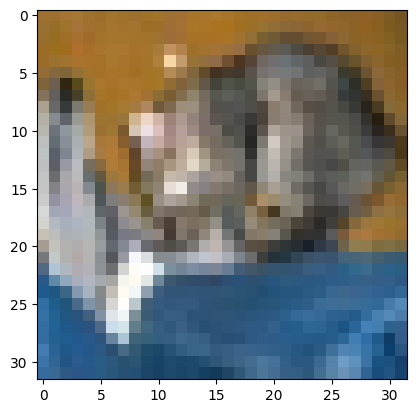

In [23]:
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np

ref = importlib_resources.files("finn.qnn-data") / "cifar10/cifar10-test-data-class3.npz"
with importlib_resources.as_file(ref) as fn:
    x = np.load(fn)["arr_0"]
x = x.reshape(3, 32,32).transpose(1, 2, 0)
plt.imshow(x)

In [24]:
model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_synth.onnx")
iname = model.graph.input[0].name
ishape = model.get_tensor_shape(iname)
np.save(deployment_dir + "/input.npy", x.reshape(ishape))

In [25]:
! ls {deployment_dir}

driver_base.py	finn	   qonnx	resizer.hwh	 validate.py
driver.py	input.npy  resizer.bit	runtime_weights


In [26]:
from shutil import make_archive
make_archive('deploy-on-pynq-cnv', 'zip', deployment_dir)

'/home/surajkarki/workspace/finn/notebooks/end2end_example/bnn-pynq/deploy-on-pynq-cnv.zip'

You can now download the created zipfile (File -> Open, mark the checkbox next to the deploy-on-pynq-tfc.zip and select Download from the toolbar), then copy it to your PYNQ board (for instance via scp or rsync). Then, run the following commands on the PYNQ board to extract the archive and run the execution:

```shell
unzip deploy-on-pynq-cnv.zip -d finn-cnv-demo
cd finn-cnv-demo
sudo python3 -m pip install bitstring
sudo python3 driver.py --exec_mode=execute --batchsize=1 --bitfile=resizer.bit --inputfile=input.npy
```

The output will be saved on the PYNQ board as `output.npy` and can be copied to the host and opened with `np.load()`.

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

All the command line prompts here are meant to be executed with `sudo` on the PYNQ board.

**Ensure that your PYNQ board has a working internet connecting for the next steps, since some there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ:

```shell
sudo pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading
```

We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the CIFAR-10 dataset.

Command to execute on PYNQ:

```shell
sudo python3 validate.py --dataset cifar10 --batchsize 1000
```

We see that the final top-1 accuracy is 84.19%, which is very close to the 84.22% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). 